<a href="https://colab.research.google.com/github/meashu31/AIML-Capstone-CV9/blob/Vadhi_master/Unet_Models_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Gogle Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
pip install segmentation-models

In [34]:
#------------------------- Load necessary libraries -------------------------#
####------------------------- for loading path -------------------------#
import os
####------------------------- for DataGenerator -------------------------#
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
####------------------------- for Plotting -------------------------#
import matplotlib.pyplot as plt
####------------------------- for Model -------------------------#
from keras.utils.layer_utils import count_params
from tabulate import tabulate
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import pandas as pd
from IPython.display import clear_output
import calendar
import time
import datetime
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *

Segmentation Models: using `keras` framework.


In [17]:
path = '/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/'
os.chdir(path) #changing the current directory path to the project direcotry where the dataset is available
path = os.getcwd() # directory path of all the images

In [18]:
im_path = path +'/data/image_data/images/'
mask_path = path + '/data/mask_data/masks/'
train_list = os.listdir(im_path)
mask_list = os.listdir(mask_path)
print('Number of train Images:',len(train_list),'\nNumber of Mask Images:',len(mask_list))
# Check for any name mismatch between images and masks
print("Number of UnCommon Images",list(set(train_list) - set(mask_list)))

Number of train Images: 26684 
Number of Mask Images: 26684
Number of UnCommon Images []


In [27]:
image_gen_args = dict(featurewise_center=True,rotation_range=90,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,validation_split=0.2,zoom_range=0.2)
mask_gen_args = dict(featurewise_center=True,rotation_range=90,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,validation_split=0.2,rescale=1./255,zoom_range=0.2)

image_datagen = ImageDataGenerator(**image_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)
seed = 1

image = tf.keras.preprocessing.image.load_img(im_path+train_list[0])
input_img = keras.preprocessing.image.img_to_array(image)
input_img = np.array([input_img])  # Convert single image to a batch.

print("Input image shape:",input_img.shape)

mask = tf.keras.preprocessing.image.load_img(mask_path+train_list[0], color_mode="grayscale")
input_mask = keras.preprocessing.image.img_to_array(mask,)
input_mask = np.array([input_mask])  # Convert single image to a batch.
print("Input mask shape:",input_mask.shape)

image_datagen.fit(input_img, augment=True, seed=seed)
mask_datagen.fit(input_mask, augment=True, seed=seed)

Input image shape: (1, 1024, 1024, 3)
Input mask shape: (1, 1024, 1024, 1)


In [28]:
#------------------------- Train DataSetGenerator -------------------------#
train_image_generator = image_datagen.flow_from_directory("data/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=4,shuffle=True,subset='training',seed=seed)
train_mask_generator = mask_datagen.flow_from_directory("data/mask_data",class_mode=None,color_mode="grayscale",target_size=(224,224),batch_size=4,shuffle=True,subset='training',seed=seed)
#------------------------- Validation DataSetGenerator -------------------------#
validation_image_generator = image_datagen.flow_from_directory("data/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=4,shuffle=True,subset='validation',seed=seed)
validation_mask_generator = mask_datagen.flow_from_directory("data/mask_data",class_mode=None,color_mode="grayscale",target_size=(224,224),batch_size=4,shuffle=True,subset='validation',seed=seed)

Found 21348 images belonging to 1 classes.
Found 21348 images belonging to 1 classes.
Found 5336 images belonging to 1 classes.
Found 5336 images belonging to 1 classes.


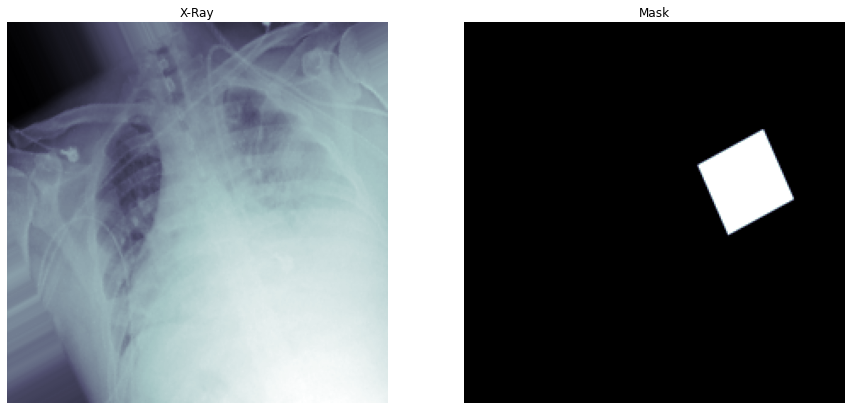

In [31]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(train_image_generator[1][0][:,:,0], cmap = plt.cm.bone)
ax1.set_title('X-Ray')
ax1.axis('off')
ax2.imshow(train_mask_generator[1][0][:,:,0], cmap = plt.cm.bone)
ax2.set_title('Mask')
ax2.axis('off')
plt.show()

In [32]:
train_generator = zip(train_image_generator, train_mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)

## Backboned-UNet

In [32]:
def create_model(Backbone='vgg16',pretrained=True,ShowSummery=False,TrainModel=True,TestModel=True):
  # preprocess input
  print("-------------------PreProcessing Input based on Bakbone Model----------------------")
  PreprocessInput = get_preprocessing(Backbone)
    #------------------------- Train DataSetGenerator -------------------------#
  image_gen_args = dict(featurewise_center=True,rotation_range=90,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,preprocessing_function=PreprocessInput,validation_split=0.2,zoom_range=0.2)
  image_datagen = ImageDataGenerator(**image_gen_args)
  image_datagen.fit(input_img, augment=True, seed=seed)
  train_image_generator = image_datagen.flow_from_directory("data/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=4,shuffle=True,subset='training',seed=seed)
      #------------------------- Validation DataSetGenerator -------------------------#
  validation_image_generator = image_datagen.flow_from_directory("data/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=4,shuffle=True,subset='validation',seed=seed)
  train_generator = zip(train_image_generator, train_mask_generator)
  validation_generator = zip(validation_image_generator, validation_mask_generator)

  # define model
  print("-------------------Generating UNet Model----------------------")
  model = Unet(Backbone, encoder_weights='imagenet', input_shape=(224, 224, 3))
  ##-------------------getLast layer and add reshape----------------------
  LastLayerIdx = len(model.layers) - 1
  LastLayerName = model.layers[LastLayerIdx].name
  for layer in model.layers:
    layer.trainable = not pretrained
    LastLayer = model.get_layer(LastLayerName).output
    x = Reshape((224, 224))(LastLayer)

  model = Model(inputs=model.input, outputs=x)
  # Model Overview
  trainable_count = count_params(model.trainable_weights)
  non_trainable_count = count_params(model.non_trainable_weights)

  print(tabulate([['Model', 'UNet'],\
                          ['BackBone', Backbone],\
                          ['Number of Layers', len(model.layers)],\
                          ['Total params', model.count_params()],\
                          ['Trainable params', trainable_count],\
                          ['Non-trainable params', non_trainable_count]],\
                          headers=['Header', 'Value'], tablefmt='orgtbl'))
  print()
  print()
  #If Choosen Show Summery
  print("-------------------Model Summery----------------------")
  if ShowSummery: model.summary()
  if TrainModel:
    print("-------------------Training Model----------------------")
    # Compile model
    model.compile('Adam', loss=bce_jaccard_loss, metrics=['accuracy',iou_score])
    # checkpoint
    ts = calendar.timegm(time.gmtime())
    readable = datetime.datetime.fromtimestamp(ts).isoformat()
    filepath = path + Backbone + "/model-"+ readable + ".h5"
    checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
    stop = EarlyStopping(monitor="loss", patience=5, mode="min")
    batch_size = 8
    model.fit(train_generator,
              epochs=5,
              steps_per_epoch = len(x_train)/batch_size,
              validation_data=validation_generator,
              validation_steps = len(x_train)/batch_size*2,
              callbacks= [checkpoint, stop])
  if TestModel:
    test_list = ['0a2c130c-c536-4651-836d-95d07e9a89cf.png','0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27.png']
    test_gen = DataGenerator(list_IDs=test_list , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True, preprocessinput=PreprocessInput)
    model.compile('Adam', loss=bce_jaccard_loss, metrics=['accuracy',iou_score])
    n = 0
    sample_image = test_gen[n][0][0]
    sample_image_redim = np.expand_dims(sample_image, axis=0)
    region = model.predict(sample_image_redim)
    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
    ax1.imshow(sample_image[:,:,0], cmap = plt.cm.bone)
    ax1.set_title('Input Image')
    ax1.axis('off')
    ax2.imshow(test_gen[n][1][0], cmap = plt.cm.bone)
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')
    ax3.imshow(region[0], cmap = plt.cm.bone)
    ax3.set_title('Predicted Mask (no threshold applied)')
    ax3.axis('off')
    plt.show()

In [4]:
print(tabulate([['UNet', 'VGG-16', 67, 23752273],\
                ['UNet', 'VGG-19', 70, 29061969],\
                ['UNet', 'ResNet-18', 128, 14340570],\
                ['UNet', 'ResNet-34', 200, 24456154],\
                ['UNet', 'ResNet-50', 232, 32561114],\
                ['UNet', 'ResNet-101', 419, 51605466],\
                ['UNet', 'ResNet-152', 606, 67295194],\
                ['UNet', 'DenseNet-121', 469, 12144977],\
                ['UNet', 'DenseNet-169', 637, 19519825],\
                ['UNet', 'DenseNet-201', 749, 26378577],\
                ['UNet', 'Inception-V3', 353, 29933105],\
                ['UNet', 'Inception-ResNet-V2', 822, 62061553],\
                ['UNet', 'MobileNet', 129, 8336337]],
                headers=['Model', 'Backbone', 'Number of Layers', 'Total Parameters'], tablefmt='orgtbl',stralign="center", numalign="center"))

|  Model  |      Backbone       |  Number of Layers  |  Total Parameters  |
|---------+---------------------+--------------------+--------------------|
|  UNet   |       VGG-16        |         67         |      23752273      |
|  UNet   |       VGG-19        |         70         |      29061969      |
|  UNet   |      ResNet-18      |        128         |      14340570      |
|  UNet   |      ResNet-34      |        200         |      24456154      |
|  UNet   |      ResNet-50      |        232         |      32561114      |
|  UNet   |     ResNet-101      |        419         |      51605466      |
|  UNet   |     ResNet-152      |        606         |      67295194      |
|  UNet   |    DenseNet-121     |        469         |      12144977      |
|  UNet   |    DenseNet-169     |        637         |      19519825      |
|  UNet   |    DenseNet-201     |        749         |      26378577      |
|  UNet   |    Inception-V3     |        353         |      29933105      |
|  UNet   | 

In [33]:
#------------------------- Load necessary libraries -------------------------#
from ipywidgets import widgets, Layout, Button, Box, Dropdown, Label,Output,interact, interactive_output
#------------------------- Load widgets -------------------------#
BackBoneLabel = Label(value='Select Backbone')
BackboneDrop = Dropdown(options=[('Select', ""),("VGG-16", "vgg16"),("VGG-19", "vgg19"),
                           ("ResNet-18","resnet18"),("ResNet-34","resnet34"),
                           ("ResNet-50","resnet50"),("ResNet-101","resnet101"),
                           ("ResNet-152","resnet152"),("DenseNet-121","densenet121"),
                           ("DenseNet-169","densenet169"),("DenseNet-201","densenet201"),
                           ("Inception V3","inceptionv3"),("Inception ResNet V2","inceptionresnetv2"),
                           ("MobileNet","mobilenet")],value='')
PreTrainLabel = Label(value='Use PreTrained Weights')
PreTrainedDrop = Dropdown(options=[('Yes', True),("No", False)],value=True)
SummeryLabel = Label(value='Show Model Summary')
SummeryDrop = Dropdown(options=[('Yes', True),("No", False)],value=False)
TrainLabel = Label(value='Train Model')
TrainModel = Dropdown(options=[('Yes', True),("No", False)],value=False)
TestLabel = Label(value='Test Model')
TestModel = Dropdown(options=[('Yes', True),("No", False)],value=False)
GenerateModelButton = widgets.Button(description="Generate Model",disabled=False,button_style='success',tooltip='Click to generate model')
#------------------------- Function on Selection -------------------------#
def OnSelection(BackBoneSelection,PreTrainSelection,SummerySelection,TrainSelection,TestSelection):
  PreTrainStr = None
  ShowSummaryStr = None
  TrainModelStr = None
  TestModelStr = None
  print()
  if BackBoneSelection == "":
    print("Please select a Backbone of your choice")
  else:
    PreTrainStr = "Trained" if PreTrainSelection else "UnTrained"
    ShowSummaryStr = "be" if SummerySelection else "not be"
    TrainModelStr = "be" if SummerySelection else "not be"
    TestModelStr = "be" if TestSelection else "not be"
    print("UNet Model with",PreTrainStr,BackBoneSelection,"backbone will be loaded, Model Summary will",ShowSummaryStr,"displayed, will", TrainModelStr, "trained and will",TestModelStr, "tested with new data.")
    print()
    print("If OK with above configuration, Click Generate Model (OR) Choose required configuration from GUI")
    print()
    display(GenerateModelButton)
#------------------------- Function at Button click -------------------------#
def on_button_clicked(b):
  create_model(Backbone=BackboneDrop.value,pretrained=PreTrainedDrop.value,ShowSummery=SummeryDrop.value,TrainModel=TrainModel.value,TestModel=TestModel.value)
GenerateModelButton.on_click(on_button_clicked)
#------------------------- Make widget -------------------------#
out = interactive_output(OnSelection, {"BackBoneSelection":BackboneDrop, "PreTrainSelection":PreTrainedDrop, "SummerySelection":SummeryDrop, "TrainSelection":TrainModel, "TestSelection":TestModel})
form_item_layout = Layout(display='flex',flex_flow='row',justify_content='space-between')
form_items = [
    Box([BackBoneLabel,BackboneDrop], layout=form_item_layout),
    Box([PreTrainLabel, PreTrainedDrop], layout=form_item_layout),
    Box([SummeryLabel, SummeryDrop], layout=form_item_layout),
    Box([TrainLabel, TrainModel], layout=form_item_layout),
    Box([TestLabel, TestModel], layout=form_item_layout)]
GUI = Box(form_items, layout=Layout(display='flex',flex_flow='column',border='solid 2px',align_items='stretch',width='27%'))

In [34]:
display(GUI, out)

Box(children=(Box(children=(Label(value='Select Backbone'), Dropdown(options=(('Select', ''), ('VGG-16', 'vgg1…

Output()